In [33]:
#importing all the necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Loading the dataset

The following blocks of code, load the dataset and perform transformations on it. The following cell provides a brief explanation of each transform used in the code:

1. `RandomResizedCrop:` This transform randomly crops a portion of the image and resizes it to the desired size. It is commonly used for data augmentation to increase the variability of the images in the dataset. In the code, I used a crop size of 224, which is a common size used in many deep learning models.

2. `RandomHorizontalFlip:` This transform randomly flips the image horizontally with a probability of 0.5. This is another commonly used data augmentation technique to increase the variability of the dataset.

3. `ColorJitter:` This transform randomly adjusts the brightness, contrast, saturation, and hue of the image. It can be used to create a more robust model that is able to handle variations in lighting conditions, color distributions, and other factors that may affect the appearance of the images in the dataset.

4. `ToTensor:` This transform converts the image into a PyTorch tensor. PyTorch tensors are the primary data structure used in PyTorch for deep learning computations.

5. `Normalize:` This transform normalizes the tensor by subtracting the mean and dividing by the standard deviation. Normalization helps to bring the data into a common scale and can improve the convergence of the training process.



In [34]:
# Define the path to the directory containing the images

ROOT_PATH = "../dataset"

In [35]:
negatives = []
positives = []

for i in os.listdir(os.path.join(ROOT_PATH, "yes")):
    positives.append(os.path.join(os.path.join(ROOT_PATH, "yes"), i))

for i in os.listdir(os.path.join(ROOT_PATH, "no")):
    negatives.append(os.path.join(os.path.join(ROOT_PATH, "no"), i))

In [36]:
inputs = positives + negatives
labels = ['yes'] * len(positives) + ['no'] * len(negatives)

len(inputs), len(labels)

(254, 254)

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.33)

(456, 374)


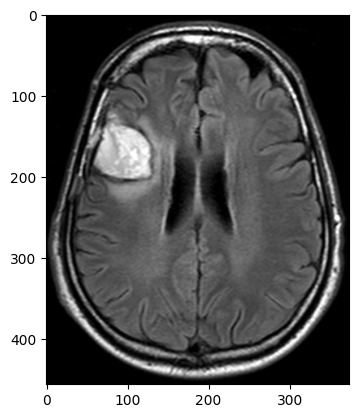

In [38]:
test_img = positives[5]
test_img = cv2.imread(test_img)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

print(test_img.shape)
plt.imshow(test_img, cmap='gray')

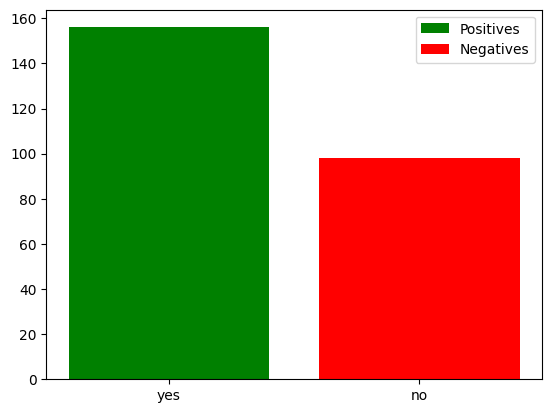

In [40]:
yes_len = len(os.listdir(f"../dataset/yes/"))
no_len = len(os.listdir(f"../dataset/no/"))
plt.bar("yes", yes_len, color='g', label="Positives")
plt.bar("no", no_len, color='r', label="Negatives")
plt.legend()
plt.show()

In [41]:
yes_len

156

In [42]:
def get_confusion_matrix(ground_truths, preds, labels):
    cm = confusion_matrix(ground_truths, preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()

In [43]:
new_size = 224

train_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((new_size, new_size)),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.5),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomPosterize(bits=2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((new_size, new_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [44]:
batch_size = 16

In [45]:
class BrainMRIDataset(Dataset):
    def __init__(self, files_paths, transforms=None):
        super().__init__()
        self.files_paths = files_paths
        self.transforms = transforms
    
    def __len__(self):
        return len(list(self.files_paths))
    
    def __getitem__(self, ix):
        image_path = self.files_paths[ix]
        label = image_path.split("/")[-2]
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        label = 1 if label == 'yes' else 0
        
        return image, label
    
    def collate_fn(self, batch):
        imgs = []
        lbs = []
        for images, labels in batch:
            if self.transforms:
                imgs.append(self.transforms(images))
            else:
                imgs.append(images)
            
            lbs.append(labels)

        imgs = [torch.tensor(i) for i in imgs]      
        imgs = torch.cat(imgs)
        imgs = imgs.unsqueeze(1)
        
        
        lbs = [torch.tensor(l)[None] for l in lbs]
        lbs = torch.cat(lbs)
        lbs = lbs.view(lbs.shape[0], 1)
#         lbs = F.one_hot(lbs, num_classes=2)
        
        return imgs.to(device), lbs.to(device)

In [46]:
train_ds = BrainMRIDataset(X_train, train_transformations)
test_ds = BrainMRIDataset(X_test, test_transformations)

train_dl = DataLoader(train_ds, collate_fn=train_ds.collate_fn, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, collate_fn=test_ds.collate_fn, batch_size=batch_size, shuffle=True)

In [54]:
class BrainMRIModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.dimensions = 32 * 32
        
        self.brain_mri_model = models.resnet18(pretrained=True)
        
        for param in self.brain_mri_model.parameters():
            param.requires_grad = False
        
        # Modify the model based on my dataset
        self.brain_mri_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.brain_mri_model.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.Dropout(p=0.4, inplace=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(p=0.4, inplace=False),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.brain_mri_model(x)
        

In [48]:
def measure_accuracy(preds, labels):
    acc = ((preds > 0.5) == labels).float()
    acc = torch.sum(acc) / len(labels)
    
    return acc.detach()        

In [49]:
def get_confusion_matrix(preds, labels, classes):
    # TODO: Search for methods to do this more efficiently
    
    y_train_, total_predictions_ = [], []

    # Convert the labels to number
    for i in labels:
        if i == 'yes':
            y_train_.append(1)
        else:
            y_train_.append(0)

    # Convert the preds to int
    for i in preds:
        x = int(i[0])
        total_predictions_.append(x)
    cm = confusion_matrix(total_predictions_, y_train_, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    plt.rcParams["figure.figsize"] = (9, 9)
    disp.plot()
    plt.show()

In [50]:
# TODO: Implement a True Positive Rate and a False Positive Rate calculator
# TODO: Implement a callback function

total_predictions = []

def train_batch(data, model, criterion, optimizer, islast=False):
    images, labels = data    
    
    labels = labels.float()
    
    model.train()
    preds = model(images)
    
    # Measure loss
    loss = criterion(preds.float(), labels)
    # Measure accuracy
    acc = measure_accuracy(preds, labels)
    
    # Preprocess data for the confusion matrix
    binary_preds = ((preds > 0.5) == labels).float()
    
    if islast:
        total_predictions.extend(binary_preds)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.detach().item(), acc
    
    # True Positives Rate
#     tpr = 1 if (preds > 0.5) else 0

In [51]:
predictions_for_cm = []

@torch.no_grad()
def test_batch(data, model, criterion):
    global predictions_for_cm

    model.eval()
    
    images, labels = data    
    labels = labels.float()
    
    with torch.no_grad():
        preds = model(images)
        
        # Preprocess data for the confusion matrix
        binary_preds = ((preds > 0.5) == labels).float()
        
        predictions_for_cm.extend(binary_preds)
        loss = criterion(preds.float(), labels)
        acc = measure_accuracy(preds, labels)
        
        return loss.detach().item(), acc

In [52]:
def early_stopping(old_values, min_increment, window=3):
    """
    Returns True if it should stop earlier.
    """
    values_in_window = []
    
    if len(old_values) >= window:
        values_in_window = old_values[window:]
    else:
        values_in_window = old_values
    
    last_value = values_in_window[-1]
    avg_last_values = np.mean(values_in_window)
    
    if avg_last_values - last_value < min_increment:
        return True
    return False

In [57]:
n_epochs = 75
model = BrainMRIModel().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

training_loss, training_acc = [], []

is_last_epoch = False
stop = False

for ex in range(n_epochs):
    
    training_loss_per_epoch, training_acc_per_epoch = [], []
    
    print(f"Epoch {ex+1}")
    is_last_epoch = True if ex + 1 == n_epochs else False
    
    for ix, data in enumerate(train_dl):
        loss, acc = train_batch(data, model, criterion, optimizer, is_last_epoch)
        training_loss_per_epoch.append(np.asarray(loss))
        training_acc_per_epoch.append(np.asarray(acc))
    
    #torch.save(model.state_dict(), f"./saved_models/brain_mri_model_{ex+1}.pt")
    
    training_loss.append(np.asarray(training_loss_per_epoch).mean())
    training_acc.append(np.asarray(training_acc_per_epoch).mean())
    
#     stop = early_stopping(training_loss, 0.05, 5)
    
#     if stop:
#         break

Epoch 1


/home/rubabatwal/miniconda3/envs/ese-msc/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75


In [58]:
training_loss

[0.5857475779273293,
 0.5638847242702137,
 0.5213130197741769,
 0.4926148747855967,
 0.5100424669005654,
 0.3954689285971902,
 0.41369290243495593,
 0.46211531487378205,
 0.4114468206058849,
 0.44252692840316077,
 0.35382783819328656,
 0.37956631590019574,
 0.42408788204193115,
 0.38222863186489453,
 0.4243283434347673,
 0.40622934157198126,
 0.3831646970727227,
 0.35372935100035235,
 0.35446029901504517,
 0.3326350450515747,
 0.40852840922095557,
 0.36573351513255725,
 0.292833226648244,
 0.4084581888534806,
 0.33738940954208374,
 0.3916029693050818,
 0.39119467681104486,
 0.3601439608768983,
 0.299241457473148,
 0.2989001111550765,
 0.3232049589807337,
 0.3707948354157535,
 0.3803904056549072,
 0.2825868685137142,
 0.34601526097817853,
 0.4673639888113195,
 0.3173623193394054,
 0.41200681030750275,
 0.3071294575929642,
 0.27589739994569257,
 0.3807151141491803,
 0.3178279413418336,
 0.35504578053951263,
 0.3494929075241089,
 0.3135024607181549,
 0.35769103467464447,
 0.35406181487170

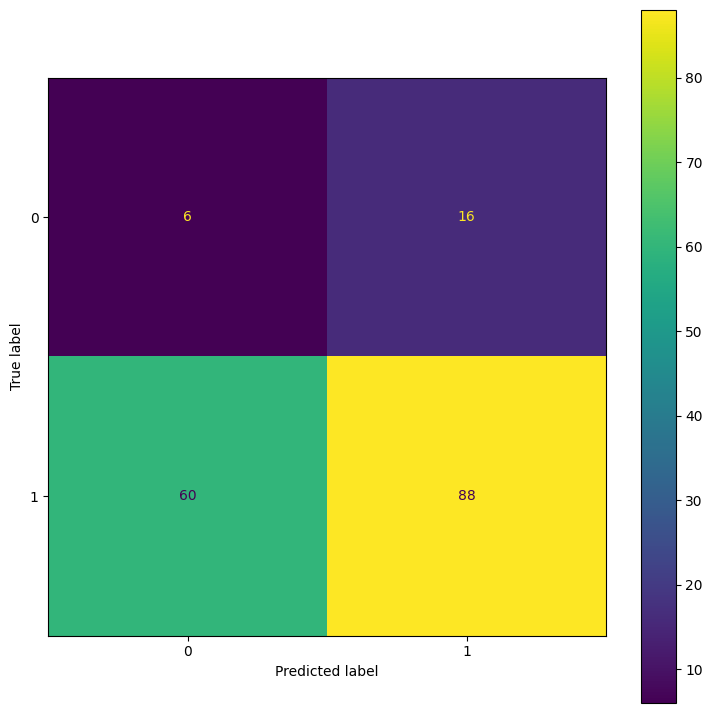

In [59]:
get_confusion_matrix(total_predictions, y_train, [0, 1])

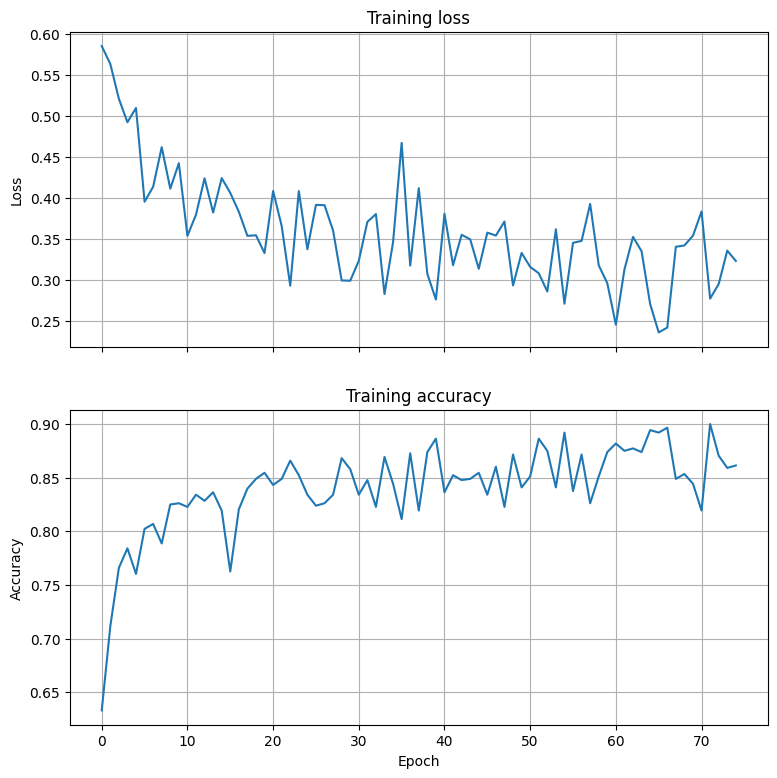

In [60]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9, 9))

ax1.plot(training_loss)
ax1.set_title("Training loss")
ax1.set(ylabel="Loss")
ax1.grid()

ax2.plot(training_acc)
ax2.set_title("Training accuracy")
ax2.set(ylabel="Accuracy", xlabel="Epoch")
ax2.grid()

plt.show()

In [61]:
test_loss, test_acc = [], []

for ix, data in enumerate(test_dl):
    loss, acc = test_batch(data, model, criterion)
    test_loss.append(np.asarray(loss).mean())
    test_acc.append(np.asarray(acc).mean())

/home/rubabatwal/miniconda3/envs/ese-msc/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


error: OpenCV(4.7.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
print(len(predictions_for_cm), len(y_test))
get_confusion_matrix(predictions_for_cm, y_test, [0, 1])

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(9, 9))

ax1.plot(test_loss)
ax1.set_title("Testing loss")
ax1.set(ylabel="Loss")
ax1.grid()

ax2.plot(test_acc)
ax2.set_title("Testing accuracy")
ax2.set(ylabel="Accuracy", xlabel="Epoch")
ax2.grid()

plt.show()
